<a href="https://colab.research.google.com/github/shawrab/ML-and-DL-based-prediction-of-hypertension-and-analysis-of-its-major-risk-factors-in-Bangladesh/blob/main/Python_Code_for_Hypertension_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Necessary Libraries

In [ ]:
# Install dependencies
!pip install pytorch-tabnet xgboost lightgbm scikit-learn tensorflow matplotlib --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, roc_curve
)

from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import statsmodels.api as sm
from statistics import mean, stdev
from sklearn.model_selection import StratifiedGroupKFold
from sklearn import linear_model

from lightgbm import LGBMClassifier

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


# Weighted Logistic Regression

## Data Preprocessing

In [ ]:
# Load Data
data = pd.read_stata("/content/final_data.dta")

X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
X = pd.get_dummies(X).astype(int)

new_names = ['Sex (Male)', 'Sex (Female)', 'Age Group (18–34)', 'Age Group (35–59)',
       'Age Group (60+)', 'Family Size (Small)', 'Family Size (Medium)',
       'Family Size (Large)', 'Marital Status (Never married)',
       'Marital Status (Married)', 'Division (Barisal)', 'Division (Chittagong)',
       'Division (Dhaka)', 'Division (Khulna)', 'Division (Mymensingh)',
       'Division (Rajshahi)', 'Division (Rangpur)', 'Division (Sylhet)',
       'Residence Type (Urban)', 'Residence Type (Rural)', 'Wealth Index (Poorest)',
       'Wealth Index (Poorer)', 'Wealth Index (Middle)', 'Wealth Index (Richer)',
       'Wealth Index (Richest)', 'Education Level (No/Primary)',
       'Education Level (Secondary/Higher)', 'BMI Category (Underweight)',
       'BMI Category (Normal)', 'BMI Category (Obese/Overweight)', 'Diabetes Status (No)',
       'Diabetes Status (Yes)']
X.columns = new_names
y = (data['hypertension'] == "Yes").astype(int)
weights = data['sampling_weight']

X_train, X_test, y_train, y_test_wlr, w_train, w_test = train_test_split(
    X, y, weights,
    test_size=0.2,
    stratify=y,
    random_state=0
)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

## Model Define

In [ ]:
# Define the model
model = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Binomial(),
    freq_weights=w_train
)

# fit the model
result = model.fit()

# Make predictions with the model
y_train_prob = result.predict(X_train).ravel()
y_test_prob_wlr  = result.predict(X_test).ravel()

# Create an accuracy metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),          # Sensitivity
        "Specificity": tn / (tn + fp),
        "F1-score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_prob),
        "AUC-PR": average_precision_score(y_true, y_prob)
    }

# Compute metrics
train_results = compute_metrics(y_train, y_train_prob)
test_results  = compute_metrics(y_test_wlr, y_test_prob_wlr)

# Present results in a table
results_df = pd.DataFrame([
    {"Model": "WLR", "Dataset": "Train", **train_results},
    {"Model": "WLR", "Dataset": "Test",  **test_results}
])
print(results_df.round(3))

/tmp/ipython-input-685450974.py:13: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train_prob = result.predict(X_train).ravel()
/tmp/ipython-input-685450974.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test_prob_wlr  = result.predict(X_test).ravel()


  Model Dataset  Accuracy  Precision  Recall  Specificity  F1-score  AUC-ROC  \
0   WLR   Train     0.820      0.505   0.078        0.983     0.135    0.748   
1   WLR    Test     0.817      0.444   0.070        0.981     0.121    0.751   

   AUC-PR  
0   0.371  
1   0.357  


## Feature importance by Shap Analyis

In [ ]:
import shap
explainer = shap.Explainer(result.predict, X_test)
shap_values = explainer(X_test)
shap.initjs()

PermutationExplainer explainer: 2858it [00:38, 62.33it/s]                          


/tmp/ipython-input-1374509375.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)


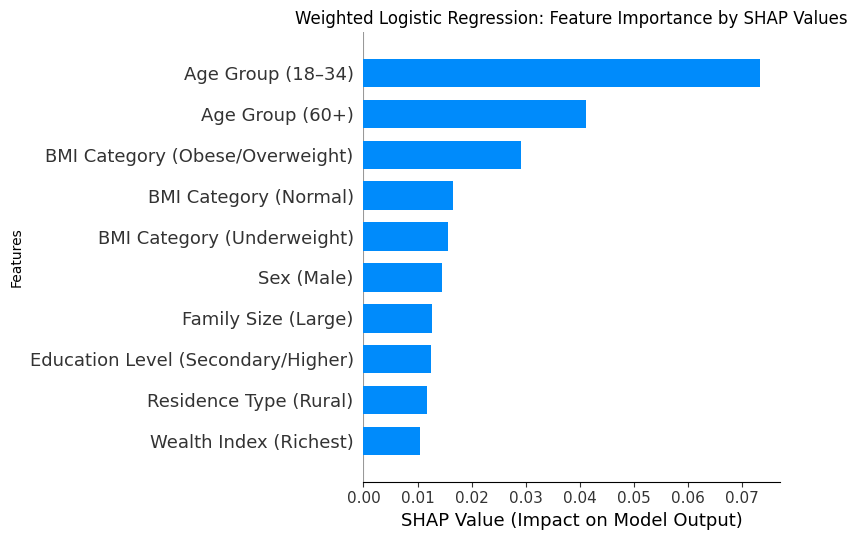

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)
plt.xlabel("SHAP Value (Impact on Model Output)")
plt.ylabel("Features")
plt.title("Weighted Logistic Regression: Feature Importance by SHAP Values")
plt.tight_layout()
plt.savefig("WLR_SHAP_summary_plot.jpg", dpi=600, bbox_inches='tight')
plt.show()

## Cross validation for weighted logistic regression model

In [ ]:
# Load data
data = pd.read_stata("/content/final_data.dta")

X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
X = pd.get_dummies(X).astype(int)

y = (data['hypertension'] == "Yes").astype(int)
groups = data['cluster']
weights = data['sampling_weight']

# Metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": tn / (tn + fp),
        "F1": f1_score(y_true, y_pred),
        "AUC_ROC": roc_auc_score(y_true, y_prob),
        "AUC_PR": average_precision_score(y_true, y_prob)
    }

# K values
k_values = [5, 10]
all_results = []

for k in k_values:

    print(f"\nRunning Weighted Logistic Regression with {k}-Fold CV")

    cv = StratifiedGroupKFold(
        n_splits=k,
        shuffle=True,
        random_state=42
    )

    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "Specificity": [],
        "F1": [],
        "AUC_ROC": [],
        "AUC_PR": []
    }

    for train_idx, test_idx in cv.split(X, y, groups):

        # Split
        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]

        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]

        w_train = weights.iloc[train_idx]

        # Add constant
        X_train_const = sm.add_constant(X_train)
        X_test_const  = sm.add_constant(X_test)

        # Weighted Logistic Regression
        model = sm.GLM(
            y_train,
            X_train_const,
            family=sm.families.Binomial(),
            freq_weights=w_train
        ).fit()

        # Prediction
        y_prob = model.predict(X_test_const)

        # Metrics
        fold_metrics = compute_metrics(y_test, y_prob)

        for key in results:
            results[key].append(fold_metrics[key])

    # Summary for this K
    cv_results = pd.DataFrame(results)

    summary = pd.DataFrame({
        "K_Fold": k,
        "Metric": cv_results.columns,
        "Mean": cv_results.mean().values,
        "SD": cv_results.std().values
    })

    all_results.append(summary)

# Final Results
final_results = pd.concat(all_results, ignore_index=True)
print(final_results.round(3))


Running Weighted Logistic Regression with 5-Fold CV

Running Weighted Logistic Regression with 10-Fold CV
    K_Fold       Metric   Mean     SD
0        5     Accuracy  0.820  0.013
1        5    Precision  0.503  0.035
2        5       Recall  0.081  0.001
3        5  Specificity  0.982  0.003
4        5           F1  0.140  0.002
5        5      AUC_ROC  0.747  0.011
6        5       AUC_PR  0.365  0.018
7       10     Accuracy  0.820  0.007
8       10    Precision  0.503  0.072
9       10       Recall  0.080  0.016
10      10  Specificity  0.983  0.004
11      10           F1  0.138  0.026
12      10      AUC_ROC  0.745  0.022
13      10       AUC_PR  0.369  0.035


# Random Forest Model

## Data Preprocessing

In [ ]:
# Load Data
data = pd.read_stata("/content/final_data.dta")  # Update path if needed

# Split features and target
X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
y = data['hypertension']

# One-hot encode categorical variables
X = pd.get_dummies(X).astype(int)
new_names = ['Sex (Male)', 'Sex (Female)', 'Age Group (18–34)', 'Age Group (35–59)',
       'Age Group (60+)', 'Family Size (Small)', 'Family Size (Medium)',
       'Family Size (Large)', 'Marital Status (Never married)',
       'Marital Status (Married)', 'Division (Barisal)', 'Division (Chittagong)',
       'Division (Dhaka)', 'Division (Khulna)', 'Division (Mymensingh)',
       'Division (Rajshahi)', 'Division (Rangpur)', 'Division (Sylhet)',
       'Residence Type (Urban)', 'Residence Type (Rural)', 'Wealth Index (Poorest)',
       'Wealth Index (Poorer)', 'Wealth Index (Middle)', 'Wealth Index (Richer)',
       'Wealth Index (Richest)', 'Education Level (No/Primary)',
       'Education Level (Secondary/Higher)', 'BMI Category (Underweight)',
       'BMI Category (Normal)', 'BMI Category (Obese/Overweight)', 'Diabetes Status (No)',
       'Diabetes Status (Yes)']
X.columns = new_names

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Yes=1, No=0

# Train-test split
X_train, X_test, y_train, y_test_rf = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Apply SMOTE in the dataset
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Hyperparameter tuning for Random forest model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [20, 50, 100, 150, 200, 300]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train_smote, y_train_smote)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

Best Parameters: {'n_estimators': 150}
Best Estimator: RandomForestClassifier(n_estimators=150)


## Model Define

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_leaf=30,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train_smote, y_train_smote)

# Make predictions with the model
y_train_prob = rf_model.predict(X_train_smote).ravel()
y_test_prob_rf  = rf_model.predict(X_test).ravel()

# Create an accuracy metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),          # Sensitivity
        "Specificity": tn / (tn + fp),
        "F1-score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_prob),
        "AUC-PR": average_precision_score(y_true, y_prob)
    }

# Compute metrics
train_results = compute_metrics(y_train_smote, y_train_prob)
test_results  = compute_metrics(y_test_rf, y_test_prob_rf)

# Present results in a table
results_df = pd.DataFrame([
    {"Model": "RF", "Dataset": "Train", **train_results},
    {"Model": "RF", "Dataset": "Test",  **test_results}
])
print(results_df.round(3))

  Model Dataset  Accuracy  Precision  Recall  Specificity  F1-score  AUC-ROC  \
0    RF   Train     0.758      0.733   0.814        0.703     0.771    0.758   
1    RF    Test     0.709      0.345   0.687        0.713     0.460    0.700   

   AUC-PR  
0   0.689  
1   0.294  


## Feature importance by SHAP analysis

In [ ]:
import shap
explainer = shap.Explainer(rf_model.predict, X_test)
shap_values = explainer(X_test)
shap.initjs()

PermutationExplainer explainer: 2858it [15:46,  3.00it/s]


/tmp/ipython-input-1312341260.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)


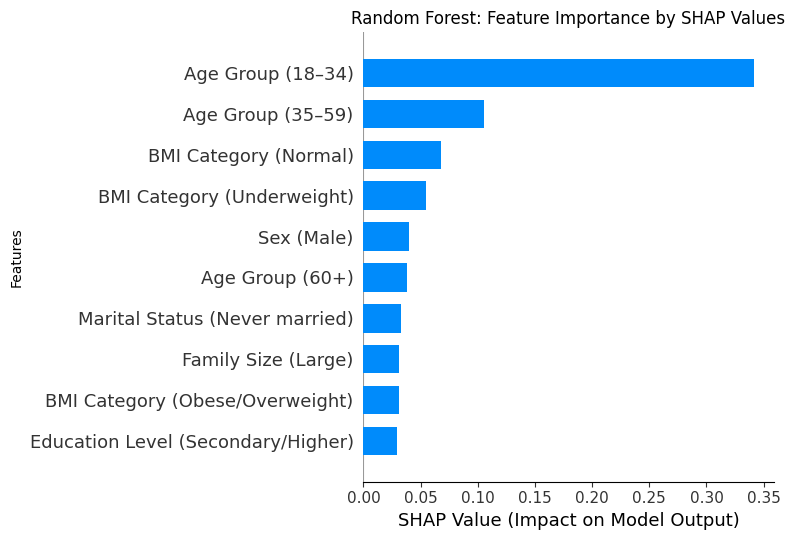

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)
plt.xlabel("SHAP Value (Impact on Model Output)")
plt.ylabel("Features")
plt.title("Random Forest: Feature Importance by SHAP Values")
plt.tight_layout()
plt.savefig("RF_SHAP_summary_plot.jpg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Cross validation for random forest model

In [ ]:
# Load data
data = pd.read_stata("/content/final_data.dta")

X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
X = pd.get_dummies(X).astype(int)

y = (data['hypertension'] == "Yes").astype(int)
groups = data['cluster']

# Metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": tn / (tn + fp),
        "F1": f1_score(y_true, y_pred),
        "AUC_ROC": roc_auc_score(y_true, y_prob),
        "AUC_PR": average_precision_score(y_true, y_prob)
    }

# K values
k_values = [5, 10]

all_results = []

for k in k_values:

    print(f"\nRunning random forest with {k}-Fold CV")

    cv = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=42)

    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "Specificity": [],
        "F1": [],
        "AUC_ROC": [],
        "AUC_PR": []
    }

    for train_idx, test_idx in cv.split(X, y, groups):

        # Split
        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]

        # SMOTE (train only)
        smote = SMOTE(random_state=42)
        X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

        # LightGBM Model
        model = RandomForestClassifier(
            n_estimators=150,
            max_depth=10,
            min_samples_leaf=30,
            class_weight="balanced",
            random_state=42
            )


        model.fit(X_train_sm, y_train_sm)

        # Prediction
        y_prob = model.predict_proba(X_test)[:, 1]

        # Metrics
        fold_metrics = compute_metrics(y_test, y_prob)

        for key in results:
            results[key].append(fold_metrics[key])

    # Summary for this K
    cv_results = pd.DataFrame(results)

    summary = pd.DataFrame({
        "K_Fold": k,
        "Metric": cv_results.columns,
        "Mean": cv_results.mean().values,
        "SD": cv_results.std().values
    })

    all_results.append(summary)

# Final Results
final_results = pd.concat(all_results, ignore_index=True)
print(final_results.round(3))


Running random forest with 5-Fold CV

Running random forest with 10-Fold CV
    K_Fold       Metric   Mean     SD
0        5     Accuracy  0.698  0.012
1        5    Precision  0.332  0.022
2        5       Recall  0.668  0.021
3        5  Specificity  0.704  0.015
4        5           F1  0.443  0.017
5        5      AUC_ROC  0.749  0.013
6        5       AUC_PR  0.361  0.016
7       10     Accuracy  0.692  0.020
8       10    Precision  0.329  0.026
9       10       Recall  0.675  0.027
10      10  Specificity  0.696  0.023
11      10           F1  0.442  0.027
12      10      AUC_ROC  0.748  0.021
13      10       AUC_PR  0.366  0.031


# LightGBM model

## Data Preprocessing

In [ ]:
# Load Data
data = pd.read_stata("/content/final_data.dta")  # Update path if needed

# Split features and target
X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
y = data['hypertension']

# One-hot encode categorical variables
X = pd.get_dummies(X).astype(int)

# Encode target (Yes=1, No=0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test_lightgbm = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE (train only)
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


## Hyperparameter tuning for LightGBM


In [ ]:
# Define a range of values for the hyperparameters to search through
param_grid = {
    'num_leaves': [5, 20, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [20, 50, 100, 150, 200, 300]
}

# Initialize an empty dictionary to store the best hyperparameters and their values
best_hyperparameters = {}
best_values = {}

# Initialize the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(objective='multiclass', num_class=3, boosting_type='gbdt')

# Initialize GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid,
                           scoring='accuracy', cv=5)

# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 14982, number of used features: 32
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 14982, num

In [ ]:
best_params

{'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 50}

## Model Define

In [ ]:
# LightGBM Model
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.01,
    num_leaves=50,
    max_depth=7,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42
)

lgbm_model.fit(X_train_smote, y_train_smote)

# Predictions
y_train_prob = lgbm_model.predict_proba(X_train_smote)[:, 1]
y_test_prob_lightgbm  = lgbm_model.predict_proba(X_test)[:, 1]

# Metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),          # Sensitivity
        "Specificity": tn / (tn + fp),
        "F1-score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_prob),
        "AUC-PR": average_precision_score(y_true, y_prob)
    }

# Compute metrics
train_results = compute_metrics(y_train_smote, y_train_prob)
test_results  = compute_metrics(y_test_lightgbm, y_test_prob_lightgbm)

# Present results
results_df = pd.DataFrame([
    {"Model": "LightGBM", "Dataset": "Train", **train_results},
    {"Model": "LightGBM", "Dataset": "Test",  **test_results}
])

print(results_df.round(3))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9364, number of negative: 9364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 18728, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

## Cross validation for LightGBM

In [ ]:
# Load data
data = pd.read_stata("/content/final_data.dta")

X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
X = pd.get_dummies(X).astype(int)

y = (data['hypertension'] == "Yes").astype(int)
groups = data['cluster']

# Metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": tn / (tn + fp),
        "F1": f1_score(y_true, y_pred),
        "AUC_ROC": roc_auc_score(y_true, y_prob),
        "AUC_PR": average_precision_score(y_true, y_prob)
    }

#  K values
k_values = [5, 10]

all_results = []

for k in k_values:

    print(f"\nRunning LightGBM with {k}-Fold CV")

    cv = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=42)

    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "Specificity": [],
        "F1": [],
        "AUC_ROC": [],
        "AUC_PR": []
    }

    for train_idx, test_idx in cv.split(X, y, groups):

        # Split
        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]

        # SMOTE (train only)
        smote = SMOTE(random_state=42)
        X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

        # LightGBM Model
        model = LGBMClassifier(
            n_estimators=300,
            learning_rate=0.01,
            num_leaves=50,
            max_depth=7,
            min_child_samples=30,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=1.0,
            random_state=42
            )

        model.fit(X_train_sm, y_train_sm)

        # Prediction
        y_prob = model.predict_proba(X_test)[:, 1]

        # Metrics
        fold_metrics = compute_metrics(y_test, y_prob)

        for key in results:
            results[key].append(fold_metrics[key])

    # Summary for this K
    cv_results = pd.DataFrame(results)

    summary = pd.DataFrame({
        "K_Fold": k,
        "Metric": cv_results.columns,
        "Mean": cv_results.mean().values,
        "SD": cv_results.std().values
    })

    all_results.append(summary)

# Final Results
final_results = pd.concat(all_results, ignore_index=True)
print(final_results.round(3))


Running LightGBM with 5-Fold CV
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9391, number of negative: 9391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 18782, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

# XGBoost model

## Data Preprocessing

In [ ]:
# Load Data
data = pd.read_stata("/content/final_data.dta")

# Split features and target
X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
y = data['hypertension']

# One-hot encode categorical variables
X = pd.get_dummies(X).astype(int)

# Encode target (Yes=1, No=0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test_xgboost = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE (train only)
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Hyperparameter tuning

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5,0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8,]
}

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit model
grid_search.fit(X_train_smote, y_train_smote)

# Best hyperparameters
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())

print("Best AUC:", grid_search.best_score_)
print("Best hyperparameters:")
print(best_params)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best AUC: 0.9412183777215573
Best hyperparameters:
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}


## Model Define

In [ ]:
model = XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=9,
            min_child_weight=10,
            subsample=0.8,
            colsample_bytree=0.7,
            reg_alpha=1,
            reg_lambda=1,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
            )
xgb_model.fit(X_train_smote, y_train_smote, verbose=1)

# Predictions
y_train_prob = xgb_model.predict_proba(X_train_smote)[:, 1]
y_test_prob_xgboost  = xgb_model.predict_proba(X_test)[:, 1]

# Metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),          # Sensitivity
        "Specificity": tn / (tn + fp),
        "F1-score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_prob),
        "AUC-PR": average_precision_score(y_true, y_prob)
    }

# Compute metrics
train_results = compute_metrics(y_train_smote, y_train_prob)
test_results  = compute_metrics(y_test_xgboost, y_test_prob_xgboost)

# Present results
results_df = pd.DataFrame([
    {"Model": "XGBoost", "Dataset": "Train", **train_results},
    {"Model": "XGBoost", "Dataset": "Test",  **test_results}
])

print(results_df.round(3))

     Model Dataset  Accuracy  Precision  Recall  Specificity  F1-score  \
0  XGBoost   Train     0.882      0.900   0.860        0.904     0.880   
1  XGBoost    Test     0.787      0.392   0.328        0.888     0.357   

   AUC-ROC  AUC-PR  
0    0.955   0.962  
1    0.722   0.337  


## Cross Validation for XGBoost model

In [ ]:
from xgboost import XGBClassifier

# Load data
data = pd.read_stata("/content/final_data.dta")

X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
X = pd.get_dummies(X).astype(int)

y = (data['hypertension'] == "Yes").astype(int)
groups = data['cluster']

# Metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": tn / (tn + fp),
        "F1": f1_score(y_true, y_pred),
        "AUC_ROC": roc_auc_score(y_true, y_prob),
        "AUC_PR": average_precision_score(y_true, y_prob)
    }

# K values
k_values = [5, 10]
all_results = []

for k in k_values:

    print(f"\nRunning XGBoost with {k}-Fold CV")

    cv = StratifiedGroupKFold(
        n_splits=k,
        shuffle=True,
        random_state=42
    )

    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "Specificity": [],
        "F1": [],
        "AUC_ROC": [],
        "AUC_PR": []
    }

    for train_idx, test_idx in cv.split(X, y, groups):

        # Split
        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]

        # SMOTE (train only)
        smote = SMOTE(random_state=42)
        X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

        # XGBoost Model
        model = XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=9,
            min_child_weight=10,
            subsample=0.8,
            colsample_bytree=0.7,
            reg_alpha=1,
            reg_lambda=1,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
            )

        model.fit(X_train_sm, y_train_sm)

        # Prediction
        y_prob = model.predict_proba(X_test)[:, 1]

        # Metrics
        fold_metrics = compute_metrics(y_test, y_prob)

        for key in results:
            results[key].append(fold_metrics[key])

    # Summary for this K
    cv_results = pd.DataFrame(results)

    summary = pd.DataFrame({
        "K_Fold": k,
        "Metric": cv_results.columns,
        "Mean": cv_results.mean().values,
        "SD": cv_results.std().values
    })

    all_results.append(summary)

# Final Results
final_results = pd.concat(all_results, ignore_index=True)
print(final_results.round(3))


Running XGBoost with 5-Fold CV

Running XGBoost with 10-Fold CV
    K_Fold       Metric   Mean     SD
0        5     Accuracy  0.773  0.006
1        5    Precision  0.350  0.023
2        5       Recall  0.305  0.018
3        5  Specificity  0.876  0.006
4        5           F1  0.325  0.011
5        5      AUC_ROC  0.719  0.010
6        5       AUC_PR  0.326  0.013
7       10     Accuracy  0.773  0.014
8       10    Precision  0.359  0.042
9       10       Recall  0.325  0.040
10      10  Specificity  0.872  0.016
11      10           F1  0.340  0.036
12      10      AUC_ROC  0.718  0.022
13      10       AUC_PR  0.330  0.032


# TabNet Model

## Data Preprocessing

In [ ]:
# Load Data
data = pd.read_stata("/content/final_data.dta")  # Update path if needed

# Split features and target
X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
y = data['hypertension']

# One-hot encode categorical variables
X = pd.get_dummies(X).astype(int)

# Encode target (Yes=1, No=0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test_tabnet = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE (train only)
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Hyperparameter tuning

We use default parameter

## Model Define

In [ ]:
# Prepare data
X_train_np = X_train_smote.values
y_train_np = y_train_smote
X_test_np  = X_test.values
y_test_np  = y_test

# Final TabNet model
tabnet_model = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=4,
    gamma=1.5,
    lambda_sparse=1e-3,
    optimizer_params=dict(lr=2e-2),
    verbose=1
)

tabnet_model.fit(
    X_train_np, y_train_np,
    max_epochs=100,
    patience=20,
    batch_size=64,
    virtual_batch_size=128,
    drop_last=False
)

# Predictions
y_train_prob = tabnet_model.predict_proba(X_train_np)[:, 1]
y_test_prob_tabnet  = tabnet_model.predict_proba(X_test_np)[:, 1]

# accuracy metrics
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": tn / (tn + fp),
        "F1-score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_prob),
        "AUC-PR": average_precision_score(y_true, y_prob)
    }

# Results
train_results = compute_metrics(y_train_np, y_train_prob)
test_results  = compute_metrics(y_test_tabnet, y_test_prob_tabnet)

results_df = pd.DataFrame([
    {"Model": "TabNet", "Dataset": "Train", **train_results},
    {"Model": "TabNet", "Dataset": "Test",  **test_results}
])

print(results_df.round(3))


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.6492  |  0:00:12s
epoch 1  | loss: 0.5899  |  0:00:26s
epoch 2  | loss: 0.57574 |  0:00:39s
epoch 3  | loss: 0.53184 |  0:00:51s
epoch 4  | loss: 0.42478 |  0:01:08s
epoch 5  | loss: 0.38172 |  0:01:22s
epoch 6  | loss: 0.36288 |  0:01:29s
epoch 7  | loss: 0.35633 |  0:01:36s
epoch 8  | loss: 0.34951 |  0:01:43s
epoch 9  | loss: 0.34399 |  0:01:50s
epoch 10 | loss: 0.34125 |  0:01:57s
epoch 11 | loss: 0.33234 |  0:02:04s
epoch 12 | loss: 0.33243 |  0:02:12s
epoch 13 | loss: 0.33184 |  0:02:19s
epoch 14 | loss: 0.32804 |  0:02:26s
epoch 15 | loss: 0.32419 |  0:02:39s
epoch 16 | loss: 0.31967 |  0:02:52s
epoch 17 | loss: 0.31917 |  0:03:04s
epoch 18 | loss: 0.31491 |  0:03:11s
epoch 19 | loss: 0.31507 |  0:03:18s
epoch 20 | loss: 0.3127  |  0:03:25s
epoch 21 | loss: 0.30918 |  0:03:45s
epoch 22 | loss: 0.30777 |  0:03:57s
epoch 23 | loss: 0.30295 |  0:04:12s
epoch 24 | loss: 0.30471 |  0:04:29s
epoch 25 | loss: 0.30157 |  0:04:48s
epoch 26 | loss: 0.29901 |  0:04:58s
e

## Cross Validation for Tabnet model

## 5 fold cross validation

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from pytorch_tabnet.tab_model import TabNetClassifier

# Load data
data = pd.read_stata("/content/final_data.dta")

X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
X = pd.get_dummies(X)

# Rename 'age_group' columns for better readability in plots
X = X.rename(columns={
    'age_group_18–34': 'Age (18-34)',
    'age_group_35–59': 'Age (35-59)',
    'age_group_60+': 'Age (60+)'
}).astype(int)

y = (data['hypertension'] == "Yes").astype(int)
groups = data['cluster']

# Metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": tn / (tn + fp),
        "F1": f1_score(y_true, y_pred),
        "AUC_ROC": roc_auc_score(y_true, y_prob),
        "AUC_PR": average_precision_score(y_true, y_prob)
    }

# 5-Fold Stratified Group CV
cv = StratifiedGroupKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

results = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "Specificity": [],
    "F1": [],
    "AUC_ROC": [],
    "AUC_PR": []
}

fold = 1

for train_idx, test_idx in cv.split(X, y, groups):
    print(f"Running fold {fold}")
    # Split
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # SMOTE (train only)
    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    # Convert to numpy (TabNet requirement)
    X_train_np = X_train_sm.values
    y_train_np = y_train_sm.values
    X_test_np  = X_test.values
    y_test_np  = y_test.values

    # TabNet Model
    model = TabNetClassifier(
        n_d=16,
        n_a=16,
        n_steps=4,
        gamma=1.5,
        lambda_sparse=1e-3,
        optimizer_params=dict(lr=2e-2),
        verbose=1
        )

    model.fit(
        X_train_np, y_train_np,
        max_epochs=100,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        drop_last=False
        )

    # Prediction
    y_prob = model.predict_proba(X_test_np)[:, 1]

    # Metrics
    fold_metrics = compute_metrics(y_test_np, y_prob)

    for key in results:
        results[key].append(fold_metrics[key])
    fold += 1

# Results summary
cv_results = pd.DataFrame(results)

summary = pd.DataFrame({
    "Mean": cv_results.mean(),
    "SD": cv_results.std()
})

print(summary.round(3))

Running fold 1


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76258 |  0:00:02s
epoch 1  | loss: 0.62474 |  0:00:03s
epoch 2  | loss: 0.60088 |  0:00:05s
epoch 3  | loss: 0.58359 |  0:00:06s
epoch 4  | loss: 0.58281 |  0:00:09s
epoch 5  | loss: 0.57823 |  0:00:11s
epoch 6  | loss: 0.57676 |  0:00:14s
epoch 7  | loss: 0.57133 |  0:00:16s
epoch 8  | loss: 0.56751 |  0:00:18s
epoch 9  | loss: 0.55821 |  0:00:23s
epoch 10 | loss: 0.55706 |  0:00:26s
epoch 11 | loss: 0.54963 |  0:00:30s
epoch 12 | loss: 0.54196 |  0:00:35s
epoch 13 | loss: 0.53007 |  0:00:39s
epoch 14 | loss: 0.51712 |  0:00:44s
epoch 15 | loss: 0.49797 |  0:00:48s
epoch 16 | loss: 0.47685 |  0:00:49s
epoch 17 | loss: 0.45996 |  0:00:51s
epoch 18 | loss: 0.41711 |  0:00:52s
epoch 19 | loss: 0.41088 |  0:00:54s
epoch 20 | loss: 0.39187 |  0:00:55s
epoch 21 | loss: 0.38147 |  0:00:56s
epoch 22 | loss: 0.35942 |  0:00:58s
epoch 23 | loss: 0.34581 |  0:00:59s
epoch 24 | loss: 0.33884 |  0:01:01s
epoch 25 | loss: 0.34153 |  0:01:02s
epoch 26 | loss: 0.32906 |  0:01:04s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.74806 |  0:00:01s
epoch 1  | loss: 0.63535 |  0:00:03s
epoch 2  | loss: 0.61484 |  0:00:04s
epoch 3  | loss: 0.5967  |  0:00:05s
epoch 4  | loss: 0.58429 |  0:00:07s
epoch 5  | loss: 0.57882 |  0:00:08s
epoch 6  | loss: 0.56921 |  0:00:10s
epoch 7  | loss: 0.5584  |  0:00:11s
epoch 8  | loss: 0.55282 |  0:00:12s
epoch 9  | loss: 0.54    |  0:00:14s
epoch 10 | loss: 0.52951 |  0:00:16s
epoch 11 | loss: 0.51999 |  0:00:17s
epoch 12 | loss: 0.50157 |  0:00:18s
epoch 13 | loss: 0.49232 |  0:00:20s
epoch 14 | loss: 0.47492 |  0:00:21s
epoch 15 | loss: 0.4576  |  0:00:22s
epoch 16 | loss: 0.45037 |  0:00:24s
epoch 17 | loss: 0.4258  |  0:00:25s
epoch 18 | loss: 0.40647 |  0:00:27s
epoch 19 | loss: 0.39156 |  0:00:29s
epoch 20 | loss: 0.39007 |  0:00:30s
epoch 21 | loss: 0.38625 |  0:00:31s
epoch 22 | loss: 0.3912  |  0:00:33s
epoch 23 | loss: 0.37387 |  0:00:34s
epoch 24 | loss: 0.3593  |  0:00:35s
epoch 25 | loss: 0.35198 |  0:00:36s
epoch 26 | loss: 0.35269 |  0:00:38s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76161 |  0:00:01s
epoch 1  | loss: 0.61822 |  0:00:02s
epoch 2  | loss: 0.59601 |  0:00:04s
epoch 3  | loss: 0.59469 |  0:00:05s
epoch 4  | loss: 0.58425 |  0:00:07s
epoch 5  | loss: 0.5788  |  0:00:08s
epoch 6  | loss: 0.57653 |  0:00:10s
epoch 7  | loss: 0.57329 |  0:00:11s
epoch 8  | loss: 0.57055 |  0:00:13s
epoch 9  | loss: 0.56175 |  0:00:14s
epoch 10 | loss: 0.56172 |  0:00:15s
epoch 11 | loss: 0.5615  |  0:00:17s
epoch 12 | loss: 0.55808 |  0:00:18s
epoch 13 | loss: 0.55469 |  0:00:20s
epoch 14 | loss: 0.55009 |  0:00:22s
epoch 15 | loss: 0.5516  |  0:00:23s
epoch 16 | loss: 0.552   |  0:00:24s
epoch 17 | loss: 0.54843 |  0:00:26s
epoch 18 | loss: 0.5435  |  0:00:27s
epoch 19 | loss: 0.5337  |  0:00:28s
epoch 20 | loss: 0.52478 |  0:00:30s
epoch 21 | loss: 0.50416 |  0:00:31s
epoch 22 | loss: 0.47066 |  0:00:33s
epoch 23 | loss: 0.44439 |  0:00:35s
epoch 24 | loss: 0.41    |  0:00:36s
epoch 25 | loss: 0.38027 |  0:00:37s
epoch 26 | loss: 0.36534 |  0:00:39s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.77612 |  0:00:01s
epoch 1  | loss: 0.64726 |  0:00:02s
epoch 2  | loss: 0.61911 |  0:00:04s
epoch 3  | loss: 0.60213 |  0:00:06s
epoch 4  | loss: 0.59436 |  0:00:07s
epoch 5  | loss: 0.5962  |  0:00:08s
epoch 6  | loss: 0.58834 |  0:00:10s
epoch 7  | loss: 0.58905 |  0:00:11s
epoch 8  | loss: 0.58555 |  0:00:13s
epoch 9  | loss: 0.58554 |  0:00:14s
epoch 10 | loss: 0.58564 |  0:00:16s
epoch 11 | loss: 0.58008 |  0:00:17s
epoch 12 | loss: 0.57865 |  0:00:19s
epoch 13 | loss: 0.57263 |  0:00:20s
epoch 14 | loss: 0.57291 |  0:00:21s
epoch 15 | loss: 0.56765 |  0:00:23s
epoch 16 | loss: 0.56592 |  0:00:24s
epoch 17 | loss: 0.56054 |  0:00:25s
epoch 18 | loss: 0.55446 |  0:00:27s
epoch 19 | loss: 0.54798 |  0:00:28s
epoch 20 | loss: 0.53144 |  0:00:30s
epoch 21 | loss: 0.51703 |  0:00:32s
epoch 22 | loss: 0.50285 |  0:00:33s
epoch 23 | loss: 0.46428 |  0:00:34s
epoch 24 | loss: 0.4468  |  0:00:36s
epoch 25 | loss: 0.45353 |  0:00:38s
epoch 26 | loss: 0.47365 |  0:00:39s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76006 |  0:00:01s
epoch 1  | loss: 0.62122 |  0:00:02s
epoch 2  | loss: 0.60549 |  0:00:04s
epoch 3  | loss: 0.60217 |  0:00:05s
epoch 4  | loss: 0.59717 |  0:00:07s
epoch 5  | loss: 0.5911  |  0:00:09s
epoch 6  | loss: 0.58087 |  0:00:10s
epoch 7  | loss: 0.5663  |  0:00:12s
epoch 8  | loss: 0.56223 |  0:00:13s
epoch 9  | loss: 0.55472 |  0:00:14s
epoch 10 | loss: 0.54128 |  0:00:16s
epoch 11 | loss: 0.5254  |  0:00:17s
epoch 12 | loss: 0.50908 |  0:00:19s
epoch 13 | loss: 0.50808 |  0:00:21s
epoch 14 | loss: 0.49311 |  0:00:22s
epoch 15 | loss: 0.481   |  0:00:24s
epoch 16 | loss: 0.46423 |  0:00:25s
epoch 17 | loss: 0.45688 |  0:00:26s
epoch 18 | loss: 0.44332 |  0:00:28s
epoch 19 | loss: 0.42704 |  0:00:29s
epoch 20 | loss: 0.42325 |  0:00:30s
epoch 21 | loss: 0.41568 |  0:00:32s
epoch 22 | loss: 0.40377 |  0:00:34s
epoch 23 | loss: 0.38573 |  0:00:36s
epoch 24 | loss: 0.40463 |  0:00:37s
epoch 25 | loss: 0.38102 |  0:00:39s
epoch 26 | loss: 0.38435 |  0:00:40s
e

## 10 fold cross validation

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from pytorch_tabnet.tab_model import TabNetClassifier

# Load data
data = pd.read_stata("/content/final_data.dta")

X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
X = pd.get_dummies(X)

# Rename 'age_group' columns for better readability in plots
X = X.rename(columns={
    'age_group_18–34': 'Age (18-34)',
    'age_group_35–59': 'Age (35-59)',
    'age_group_60+': 'Age (60+)'
}).astype(int)

y = (data['hypertension'] == "Yes").astype(int)
groups = data['cluster']

# Metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": tn / (tn + fp),
        "F1": f1_score(y_true, y_pred),
        "AUC_ROC": roc_auc_score(y_true, y_prob),
        "AUC_PR": average_precision_score(y_true, y_prob)
    }

# 10-Fold Stratified Group CV
cv = StratifiedGroupKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)

results = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "Specificity": [],
    "F1": [],
    "AUC_ROC": [],
    "AUC_PR": []
}

fold = 1

for train_idx, test_idx in cv.split(X, y, groups):
    print(f"Running fold {fold}")
    # Split
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # SMOTE (train only)
    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    # Convert to numpy (TabNet requirement)d
    X_train_np = X_train_sm.values
    y_train_np = y_train_sm.values
    X_test_np  = X_test.values
    y_test_np  = y_test.values

    # TabNet Model
    model = TabNetClassifier(
        n_d=16,
        n_a=16,
        n_steps=4,
        gamma=1.5,
        lambda_sparse=1e-3,
        optimizer_params=dict(lr=2e-2),
        verbose=1
        )
    model.fit(
        X_train_np, y_train_np,
        max_epochs=100,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        drop_last=False
        )

    # Prediction
    y_prob = model.predict_proba(X_test_np)[:, 1]

    # Metrics
    fold_metrics = compute_metrics(y_test_np, y_prob)

    for key in results:
        results[key].append(fold_metrics[key])
    fold += 1

# Results summary
cv_results = pd.DataFrame(results)

summary = pd.DataFrame({
    "Mean": cv_results.mean(),
    "SD": cv_results.std()
})

print(summary.round(3))

Running fold 1


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73221 |  0:00:01s
epoch 1  | loss: 0.62568 |  0:00:03s
epoch 2  | loss: 0.61775 |  0:00:04s
epoch 3  | loss: 0.60888 |  0:00:06s
epoch 4  | loss: 0.60262 |  0:00:07s
epoch 5  | loss: 0.58813 |  0:00:09s
epoch 6  | loss: 0.58467 |  0:00:11s
epoch 7  | loss: 0.56895 |  0:00:13s
epoch 8  | loss: 0.54287 |  0:00:14s
epoch 9  | loss: 0.52436 |  0:00:16s
epoch 10 | loss: 0.49907 |  0:00:17s
epoch 11 | loss: 0.48433 |  0:00:19s
epoch 12 | loss: 0.46535 |  0:00:20s
epoch 13 | loss: 0.4434  |  0:00:22s
epoch 14 | loss: 0.42047 |  0:00:24s
epoch 15 | loss: 0.38101 |  0:00:26s
epoch 16 | loss: 0.36162 |  0:00:28s
epoch 17 | loss: 0.33829 |  0:00:31s
epoch 18 | loss: 0.33213 |  0:00:32s
epoch 19 | loss: 0.33362 |  0:00:34s
epoch 20 | loss: 0.33609 |  0:00:37s
epoch 21 | loss: 0.32772 |  0:00:38s
epoch 22 | loss: 0.32732 |  0:00:40s
epoch 23 | loss: 0.33329 |  0:00:41s
epoch 24 | loss: 0.32888 |  0:00:43s
epoch 25 | loss: 0.32394 |  0:00:44s
epoch 26 | loss: 0.31911 |  0:00:45s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73931 |  0:00:01s
epoch 1  | loss: 0.61555 |  0:00:03s
epoch 2  | loss: 0.59774 |  0:00:04s
epoch 3  | loss: 0.58899 |  0:00:06s
epoch 4  | loss: 0.57289 |  0:00:08s
epoch 5  | loss: 0.55745 |  0:00:10s
epoch 6  | loss: 0.5403  |  0:00:11s
epoch 7  | loss: 0.5253  |  0:00:13s
epoch 8  | loss: 0.48259 |  0:00:14s
epoch 9  | loss: 0.45951 |  0:00:16s
epoch 10 | loss: 0.43316 |  0:00:17s
epoch 11 | loss: 0.41362 |  0:00:19s
epoch 12 | loss: 0.3818  |  0:00:20s
epoch 13 | loss: 0.36526 |  0:00:22s
epoch 14 | loss: 0.35722 |  0:00:24s
epoch 15 | loss: 0.34735 |  0:00:26s
epoch 16 | loss: 0.34186 |  0:00:27s
epoch 17 | loss: 0.33668 |  0:00:29s
epoch 18 | loss: 0.33663 |  0:00:30s
epoch 19 | loss: 0.32445 |  0:00:32s
epoch 20 | loss: 0.32433 |  0:00:34s
epoch 21 | loss: 0.32238 |  0:00:36s
epoch 22 | loss: 0.32106 |  0:00:37s
epoch 23 | loss: 0.32176 |  0:00:39s
epoch 24 | loss: 0.33113 |  0:00:40s
epoch 25 | loss: 0.3254  |  0:00:42s
epoch 26 | loss: 0.3236  |  0:00:43s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73676 |  0:00:01s
epoch 1  | loss: 0.6163  |  0:00:03s
epoch 2  | loss: 0.60079 |  0:00:04s
epoch 3  | loss: 0.59273 |  0:00:06s
epoch 4  | loss: 0.58122 |  0:00:07s
epoch 5  | loss: 0.57741 |  0:00:08s
epoch 6  | loss: 0.57076 |  0:00:11s
epoch 7  | loss: 0.57412 |  0:00:12s
epoch 8  | loss: 0.56807 |  0:00:14s
epoch 9  | loss: 0.56181 |  0:00:15s
epoch 10 | loss: 0.55862 |  0:00:17s
epoch 11 | loss: 0.55617 |  0:00:18s
epoch 12 | loss: 0.54504 |  0:00:20s
epoch 13 | loss: 0.54471 |  0:00:21s
epoch 14 | loss: 0.53245 |  0:00:23s
epoch 15 | loss: 0.51676 |  0:00:25s
epoch 16 | loss: 0.48199 |  0:00:26s
epoch 17 | loss: 0.44875 |  0:00:28s
epoch 18 | loss: 0.41779 |  0:00:29s
epoch 19 | loss: 0.39059 |  0:00:31s
epoch 20 | loss: 0.3797  |  0:00:32s
epoch 21 | loss: 0.38601 |  0:00:34s
epoch 22 | loss: 0.35814 |  0:00:36s
epoch 23 | loss: 0.34799 |  0:00:38s
epoch 24 | loss: 0.34062 |  0:00:39s
epoch 25 | loss: 0.33572 |  0:00:41s
epoch 26 | loss: 0.33456 |  0:00:42s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73461 |  0:00:01s
epoch 1  | loss: 0.61275 |  0:00:03s
epoch 2  | loss: 0.59173 |  0:00:05s
epoch 3  | loss: 0.58381 |  0:00:08s
epoch 4  | loss: 0.56737 |  0:00:12s
epoch 5  | loss: 0.54561 |  0:00:15s
epoch 6  | loss: 0.52583 |  0:00:19s
epoch 7  | loss: 0.50963 |  0:00:23s
epoch 8  | loss: 0.50033 |  0:00:26s
epoch 9  | loss: 0.4947  |  0:00:29s
epoch 10 | loss: 0.48942 |  0:00:31s
epoch 11 | loss: 0.49006 |  0:00:33s
epoch 12 | loss: 0.48166 |  0:00:35s
epoch 13 | loss: 0.46862 |  0:00:38s
epoch 14 | loss: 0.47271 |  0:00:41s
epoch 15 | loss: 0.45442 |  0:00:46s
epoch 16 | loss: 0.43226 |  0:00:51s
epoch 17 | loss: 0.42615 |  0:00:55s
epoch 18 | loss: 0.41296 |  0:00:59s
epoch 19 | loss: 0.38912 |  0:01:05s
epoch 20 | loss: 0.37655 |  0:01:09s
epoch 21 | loss: 0.36439 |  0:01:13s
epoch 22 | loss: 0.34097 |  0:01:18s
epoch 23 | loss: 0.33475 |  0:01:22s
epoch 24 | loss: 0.33578 |  0:01:25s
epoch 25 | loss: 0.33042 |  0:01:28s
epoch 26 | loss: 0.32787 |  0:01:31s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73553 |  0:00:01s
epoch 1  | loss: 0.62711 |  0:00:02s
epoch 2  | loss: 0.60799 |  0:00:04s
epoch 3  | loss: 0.59476 |  0:00:06s
epoch 4  | loss: 0.57574 |  0:00:08s
epoch 5  | loss: 0.56254 |  0:00:09s
epoch 6  | loss: 0.53507 |  0:00:11s
epoch 7  | loss: 0.51857 |  0:00:12s
epoch 8  | loss: 0.50143 |  0:00:14s
epoch 9  | loss: 0.49136 |  0:00:15s
epoch 10 | loss: 0.48945 |  0:00:17s
epoch 11 | loss: 0.48188 |  0:00:18s
epoch 12 | loss: 0.47217 |  0:00:20s
epoch 13 | loss: 0.45153 |  0:00:22s
epoch 14 | loss: 0.42211 |  0:00:23s
epoch 15 | loss: 0.40954 |  0:00:25s
epoch 16 | loss: 0.39835 |  0:00:26s
epoch 17 | loss: 0.37904 |  0:00:28s
epoch 18 | loss: 0.36737 |  0:00:30s
epoch 19 | loss: 0.3479  |  0:00:33s
epoch 20 | loss: 0.34338 |  0:00:35s
epoch 21 | loss: 0.34862 |  0:00:36s
epoch 22 | loss: 0.33567 |  0:00:38s
epoch 23 | loss: 0.33044 |  0:00:39s
epoch 24 | loss: 0.32654 |  0:00:41s
epoch 25 | loss: 0.33005 |  0:00:42s
epoch 26 | loss: 0.32636 |  0:00:44s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73773 |  0:00:01s
epoch 1  | loss: 0.62168 |  0:00:02s
epoch 2  | loss: 0.60131 |  0:00:04s
epoch 3  | loss: 0.5902  |  0:00:05s
epoch 4  | loss: 0.57839 |  0:00:07s
epoch 5  | loss: 0.57048 |  0:00:09s
epoch 6  | loss: 0.57142 |  0:00:11s
epoch 7  | loss: 0.57078 |  0:00:12s
epoch 8  | loss: 0.5713  |  0:00:14s
epoch 9  | loss: 0.5713  |  0:00:15s
epoch 10 | loss: 0.562   |  0:00:17s
epoch 11 | loss: 0.55856 |  0:00:18s
epoch 12 | loss: 0.55231 |  0:00:20s
epoch 13 | loss: 0.54995 |  0:00:22s
epoch 14 | loss: 0.53555 |  0:00:23s
epoch 15 | loss: 0.52801 |  0:00:25s
epoch 16 | loss: 0.50331 |  0:00:26s
epoch 17 | loss: 0.47862 |  0:00:28s
epoch 18 | loss: 0.47457 |  0:00:29s
epoch 19 | loss: 0.44315 |  0:00:31s
epoch 20 | loss: 0.45298 |  0:00:32s
epoch 21 | loss: 0.40897 |  0:00:34s
epoch 22 | loss: 0.38179 |  0:00:36s
epoch 23 | loss: 0.36336 |  0:00:37s
epoch 24 | loss: 0.35004 |  0:00:39s
epoch 25 | loss: 0.34435 |  0:00:40s
epoch 26 | loss: 0.3357  |  0:00:42s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.74737 |  0:00:01s
epoch 1  | loss: 0.61633 |  0:00:03s
epoch 2  | loss: 0.59291 |  0:00:04s
epoch 3  | loss: 0.58761 |  0:00:06s
epoch 4  | loss: 0.58428 |  0:00:08s
epoch 5  | loss: 0.57848 |  0:00:09s
epoch 6  | loss: 0.57932 |  0:00:11s
epoch 7  | loss: 0.57756 |  0:00:12s
epoch 8  | loss: 0.56681 |  0:00:14s
epoch 9  | loss: 0.56122 |  0:00:15s
epoch 10 | loss: 0.55172 |  0:00:17s
epoch 11 | loss: 0.54907 |  0:00:19s
epoch 12 | loss: 0.54883 |  0:00:21s
epoch 13 | loss: 0.53915 |  0:00:22s
epoch 14 | loss: 0.52762 |  0:00:24s
epoch 15 | loss: 0.50624 |  0:00:25s
epoch 16 | loss: 0.48311 |  0:00:27s
epoch 17 | loss: 0.46832 |  0:00:28s
epoch 18 | loss: 0.45407 |  0:00:30s
epoch 19 | loss: 0.44122 |  0:00:32s
epoch 20 | loss: 0.41784 |  0:00:34s
epoch 21 | loss: 0.39881 |  0:00:35s
epoch 22 | loss: 0.37857 |  0:00:37s
epoch 23 | loss: 0.39801 |  0:00:39s
epoch 24 | loss: 0.39485 |  0:00:40s
epoch 25 | loss: 0.36865 |  0:00:42s
epoch 26 | loss: 0.34888 |  0:00:43s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73492 |  0:00:01s
epoch 1  | loss: 0.62425 |  0:00:02s
epoch 2  | loss: 0.59648 |  0:00:04s
epoch 3  | loss: 0.58888 |  0:00:05s
epoch 4  | loss: 0.57864 |  0:00:07s
epoch 5  | loss: 0.56489 |  0:00:08s
epoch 6  | loss: 0.55008 |  0:00:11s
epoch 7  | loss: 0.52826 |  0:00:12s
epoch 8  | loss: 0.50684 |  0:00:14s
epoch 9  | loss: 0.48041 |  0:00:15s
epoch 10 | loss: 0.4552  |  0:00:16s
epoch 11 | loss: 0.43889 |  0:00:18s
epoch 12 | loss: 0.40687 |  0:00:19s
epoch 13 | loss: 0.39335 |  0:00:21s
epoch 14 | loss: 0.38188 |  0:00:23s
epoch 15 | loss: 0.37082 |  0:00:25s
epoch 16 | loss: 0.36085 |  0:00:26s
epoch 17 | loss: 0.34789 |  0:00:27s
epoch 18 | loss: 0.35459 |  0:00:29s
epoch 19 | loss: 0.35263 |  0:00:30s
epoch 20 | loss: 0.34347 |  0:00:32s
epoch 21 | loss: 0.34731 |  0:00:33s
epoch 22 | loss: 0.3345  |  0:00:35s
epoch 23 | loss: 0.32847 |  0:00:37s
epoch 24 | loss: 0.33213 |  0:00:39s
epoch 25 | loss: 0.32991 |  0:00:40s
epoch 26 | loss: 0.32953 |  0:00:42s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76278 |  0:00:02s
epoch 1  | loss: 0.61709 |  0:00:03s
epoch 2  | loss: 0.60238 |  0:00:05s
epoch 3  | loss: 0.59282 |  0:00:06s
epoch 4  | loss: 0.58309 |  0:00:08s
epoch 5  | loss: 0.57986 |  0:00:09s
epoch 6  | loss: 0.57421 |  0:00:11s
epoch 7  | loss: 0.56579 |  0:00:13s
epoch 8  | loss: 0.55699 |  0:00:15s
epoch 9  | loss: 0.54768 |  0:00:16s
epoch 10 | loss: 0.5335  |  0:00:18s
epoch 11 | loss: 0.50992 |  0:00:19s
epoch 12 | loss: 0.47567 |  0:00:21s
epoch 13 | loss: 0.42838 |  0:00:22s
epoch 14 | loss: 0.40934 |  0:00:24s
epoch 15 | loss: 0.38457 |  0:00:26s
epoch 16 | loss: 0.35879 |  0:00:28s
epoch 17 | loss: 0.34971 |  0:00:29s
epoch 18 | loss: 0.34255 |  0:00:31s
epoch 19 | loss: 0.33724 |  0:00:32s
epoch 20 | loss: 0.32846 |  0:00:34s
epoch 21 | loss: 0.32933 |  0:00:35s
epoch 22 | loss: 0.33649 |  0:00:37s
epoch 23 | loss: 0.33923 |  0:00:38s
epoch 24 | loss: 0.33123 |  0:00:40s
epoch 25 | loss: 0.32096 |  0:00:42s
epoch 26 | loss: 0.31665 |  0:00:43s
e

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.77665 |  0:00:01s
epoch 1  | loss: 0.61969 |  0:00:03s
epoch 2  | loss: 0.59883 |  0:00:05s
epoch 3  | loss: 0.5938  |  0:00:07s
epoch 4  | loss: 0.58037 |  0:00:08s
epoch 5  | loss: 0.57103 |  0:00:10s
epoch 6  | loss: 0.56389 |  0:00:11s
epoch 7  | loss: 0.55157 |  0:00:13s
epoch 8  | loss: 0.52942 |  0:00:14s
epoch 9  | loss: 0.50246 |  0:00:16s
epoch 10 | loss: 0.47571 |  0:00:18s
epoch 11 | loss: 0.45789 |  0:00:20s
epoch 12 | loss: 0.42792 |  0:00:21s
epoch 13 | loss: 0.4116  |  0:00:23s
epoch 14 | loss: 0.39268 |  0:00:24s
epoch 15 | loss: 0.38094 |  0:00:26s
epoch 16 | loss: 0.36971 |  0:00:27s
epoch 17 | loss: 0.35829 |  0:00:29s
epoch 18 | loss: 0.3482  |  0:00:31s
epoch 19 | loss: 0.34788 |  0:00:33s
epoch 20 | loss: 0.35159 |  0:00:34s
epoch 21 | loss: 0.34134 |  0:00:36s
epoch 22 | loss: 0.34324 |  0:00:37s
epoch 23 | loss: 0.35339 |  0:00:38s
epoch 24 | loss: 0.34581 |  0:00:40s
epoch 25 | loss: 0.33454 |  0:00:42s
epoch 26 | loss: 0.33125 |  0:00:44s
e

# MLP model

## Data Preprocessing

In [ ]:
# Load Data
data = pd.read_stata("/content/final_data.dta")

# Split features and target
X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
y = data['hypertension']

# One-hot encode categorical variables
X = pd.get_dummies(X).astype(int)

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Yes=1, No=0

# Train-test split
X_train, X_test, y_train, y_test_mlp = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Apply SMOTE in the dataset
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale the dataset
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter Tuning

Optimize parameter manually

## Model Define

In [ ]:
# Define the model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6
)

model_mlp = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_smote_scaled.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_mlp.compile(
    loss='binary_crossentropy',
    optimizer=AdamW(learning_rate=0.0005),
    metrics=['accuracy']
)

# Fit the model
model_mlp.fit(
    X_train_smote_scaled, y_train_smote,
    epochs=100,  # Increased since early stopping will cut off when done
    batch_size=64,
    validation_split=0.2,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop, lr_reduce],
    verbose=1
)
# Make predictions with the model
y_train_prob = model_mlp.predict(X_train_smote_scaled).ravel()
y_test_prob_mlp  = model_mlp.predict(X_test_scaled).ravel()

# Create an accuracy metric function
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),          # Sensitivity
        "Specificity": tn / (tn + fp),
        "F1-score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_prob),
        "AUC-PR": average_precision_score(y_true, y_prob)
    }

# Compute metrics
train_results = compute_metrics(y_train_smote, y_train_prob)
test_results  = compute_metrics(y_test_mlp, y_test_prob_mlp)

# Present results in a table
results_df = pd.DataFrame([
    {"Model": "MLP", "Dataset": "Train", **train_results},
    {"Model": "MLP", "Dataset": "Test",  **test_results}
])
print(results_df.round(3))

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6097 - loss: 0.9647 - val_accuracy: 0.6829 - val_loss: 0.8098 - learning_rate: 5.0000e-04
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7456 - loss: 0.7300 - val_accuracy: 0.7553 - val_loss: 0.6867 - learning_rate: 5.0000e-04
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7929 - loss: 0.6293 - val_accuracy: 0.7872 - val_loss: 0.6406 - learning_rate: 5.0000e-04
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8198 - loss: 0.5554 - val_accuracy: 0.8064 - val_loss: 0.6047 - learning_rate: 5.0000e-04
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8391 - loss: 0.5112 - val_accuracy: 0.8068 - val_loss: 0.5902 - learning_rate: 5.0000e-04
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8393 - loss: 0.4806 - val_accuracy: 0.8120 - val_loss: 0.5728 - learning_rate: 5.0000e-04
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.840

## 5 fold cross-validation for MLP model

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers

# Data
data = pd.read_stata("/content/final_data.dta")

X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
X = pd.get_dummies(X)

# Rename 'age_group' columns for better readability in plots
X = X.rename(columns={
    'age_group_18–34': 'Age (18-34)',
    'age_group_35–59': 'Age (35-59)',
    'age_group_60+': 'Age (60+)'
}).astype(int)

y = (data['hypertension'] == "Yes").astype(int)
groups = data['cluster']

# CV Setup
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

results = {
    "Accuracy": [], "Precision": [], "Recall": [],
    "Specificity": [], "F1": [], "AUC_ROC": [], "AUC_PR": []
}

fold = 1

for train_idx, test_idx in cv.split(X, y, groups):
    print(f"\nRunning fold {fold}")

    # Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # SMOTE (TRAIN ONLY)
    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    # Scaling
    scaler = StandardScaler()
    X_train_sm = scaler.fit_transform(X_train_sm)
    X_test_sc = scaler.transform(X_test)

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    # MLP Model
    model = Sequential([
        Dense(256, activation='relu',
              input_shape=(X_train_sm.shape[1],),
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=AdamW(learning_rate=0.0005),
        metrics=['accuracy']
    )

    model.fit(
        X_train_sm, y_train_sm,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop, lr_reduce],
        verbose=0
    )

    # Prediction
    y_prob = model.predict(X_test_sc).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["Precision"].append(precision_score(y_test, y_pred))
    results["Recall"].append(recall_score(y_test, y_pred))
    results["Specificity"].append(tn / (tn + fp))
    results["F1"].append(f1_score(y_test, y_pred))
    results["AUC_ROC"].append(roc_auc_score(y_test, y_prob))
    results["AUC_PR"].append(average_precision_score(y_test, y_prob))

    fold += 1

# Summary
cv_results = pd.DataFrame(results)

summary = pd.DataFrame({
    "Mean": cv_results.mean(),
    "SD": cv_results.std()
})

print(summary.round(3))


Running fold 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Running fold 2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Running fold 3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Running fold 4


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Running fold 5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              Mean     SD
Accuracy     0.793  0.012
Precision    0.371  0.022
Recall       0.211  0.024
Specificity  0.922  0.005
F1           0.269  0.022
AUC_ROC      0.714  0.008
AUC_PR       0.319  0.015


## 10 fold cross-validation for the MLP MODEL

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers

# Data
data = pd.read_stata("/content/final_data.dta")

X = data.drop(['hypertension', 'sampling_weight', 'cluster', 'strata'], axis=1)
X = pd.get_dummies(X)

# Rename 'age_group' columns for better readability in plots
X = X.rename(columns={
    'age_group_18–34': 'Age (18-34)',
    'age_group_35–59': 'Age (35-59)',
    'age_group_60+': 'Age (60+)'
}).astype(int)

y = (data['hypertension'] == "Yes").astype(int)
groups = data['cluster']

# CV Setup
cv = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

results = {
    "Accuracy": [], "Precision": [], "Recall": [],
    "Specificity": [], "F1": [], "AUC_ROC": [], "AUC_PR": []
}

fold = 1

for train_idx, test_idx in cv.split(X, y, groups):
    print(f"\nRunning fold {fold}")

    # Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # SMOTE (TRAIN ONLY)
    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    # Scaling
    scaler = StandardScaler()
    X_train_sm = scaler.fit_transform(X_train_sm)
    X_test_sc = scaler.transform(X_test)

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    # MLP Model
    model = Sequential([
        Dense(256, activation='relu',
              input_shape=(X_train_sm.shape[1],),
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=AdamW(learning_rate=0.0005),
        metrics=['accuracy']
    )

    model.fit(
        X_train_sm, y_train_sm,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop, lr_reduce],
        verbose=0
    )

    # Prediction
    y_prob = model.predict(X_test_sc).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["Precision"].append(precision_score(y_test, y_pred))
    results["Recall"].append(recall_score(y_test, y_pred))
    results["Specificity"].append(tn / (tn + fp))
    results["F1"].append(f1_score(y_test, y_pred))
    results["AUC_ROC"].append(roc_auc_score(y_test, y_prob))
    results["AUC_PR"].append(average_precision_score(y_test, y_prob))

    fold += 1

# Summary
cv_results = pd.DataFrame(results)

summary = pd.DataFrame({
    "Mean": cv_results.mean(),
    "SD": cv_results.std()
})

print(summary.round(3))


Running fold 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Running fold 2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Running fold 3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Running fold 4


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Running fold 5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Running fold 6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Running fold 7


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Running fold 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Running fold 9


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Running fold 10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              Mean     SD
Accuracy     0.789  0.010
Precision    0.363  0.044
Recall       0.219  0.026
Specificity  0.915  0.012
F1           0.272  0.029
AUC_ROC      0.711  0.022
AUC_PR       0.321  0.027


# ROC Curve

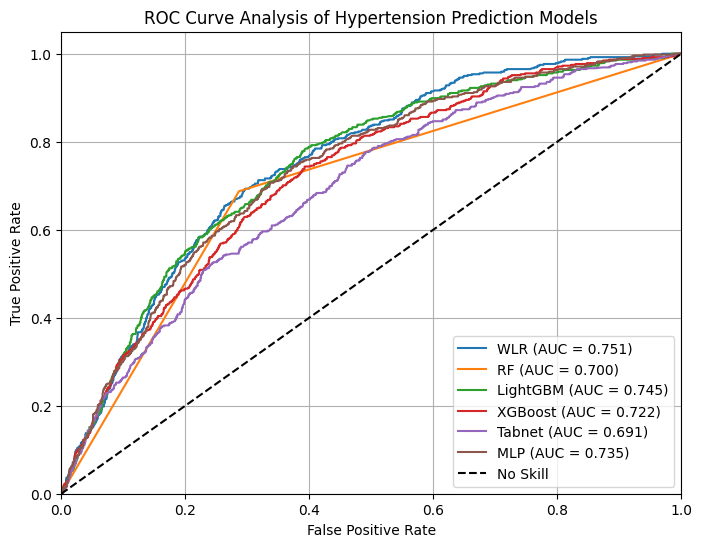

In [ ]:
# Calculate ROC curve
fpr_wlr, tpr_wlr, thresholds_wlr = roc_curve(y_test_wlr, y_test_prob_wlr)
roc_auc_wlr = auc(fpr_wlr, tpr_wlr)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_rf, y_test_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lightgbm, tpr_lightgbm, thresholds_lightgbm = roc_curve(y_test_lightgbm, y_test_prob_lightgbm)
roc_auc_lightgbm = auc(fpr_lightgbm, tpr_lightgbm)

fpr_xgboost, tpr_xgboost, thresholds_xgboost = roc_curve(y_test_xgboost, y_test_prob_xgboost)
roc_auc_xgboost = auc(fpr_xgboost, tpr_xgboost)

fpr_tabnet, tpr_tabnet, thresholds_tabnet = roc_curve(y_test_tabnet, y_test_prob_tabnet)
roc_auc_tabnet = auc(fpr_tabnet, tpr_tabnet)

fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_mlp, y_test_prob_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_wlr, tpr_wlr, label='WLR (AUC = %0.3f)' % roc_auc_wlr)
plt.plot(fpr_rf, tpr_rf, label='RF (AUC = %0.3f)' % roc_auc_rf)
plt.plot(fpr_lightgbm, tpr_lightgbm, label='LightGBM (AUC = %0.3f)' % roc_auc_lightgbm)
plt.plot(fpr_xgboost, tpr_xgboost, label='XGBoost (AUC = %0.3f)' % roc_auc_xgboost)
plt.plot(fpr_tabnet, tpr_tabnet, label='Tabnet (AUC = %0.3f)' % roc_auc_tabnet)
plt.plot(fpr_mlp, tpr_mlp, label='MLP (AUC = %0.3f)' % roc_auc_mlp)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis of Hypertension Prediction Models')
plt.legend()
plt.grid(True)
plt.savefig("ROC Curve.jpg", dpi=600, bbox_inches='tight')
plt.show()

# Precision-Recall curve


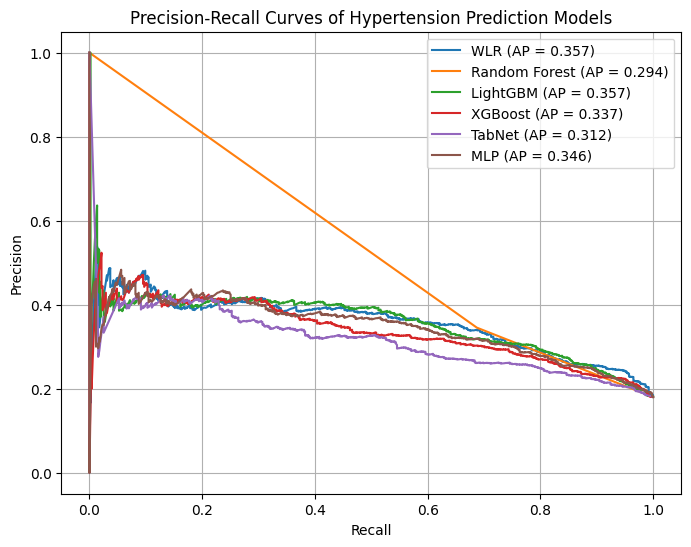

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

prec_wlr, rec_wlr, _ = precision_recall_curve(y_test_wlr, y_test_prob_wlr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test_rf, y_test_prob_rf)
prec_lightgbm, rec_lightgbm, _ = precision_recall_curve(y_test_lightgbm, y_test_prob_lightgbm)
prec_xgboost, rec_xgboost, _ = precision_recall_curve(y_test_xgboost, y_test_prob_xgboost)
prec_tabnet, rec_tabnet, _ = precision_recall_curve(y_test_tabnet, y_test_prob_tabnet)
prec_mlp, rec_mlp, _ = precision_recall_curve(y_test_mlp, y_test_prob_mlp)

plt.plot(rec_wlr, prec_wlr, label=f"WLR (AP = {average_precision_score(y_test_wlr, y_test_prob_wlr):.3f})")
plt.plot(rec_rf, prec_rf, label=f"Random Forest (AP = {average_precision_score(y_test_rf, y_test_prob_rf):.3f})")
plt.plot(rec_lightgbm, prec_lightgbm, label=f"LightGBM (AP = {average_precision_score(y_test_lightgbm, y_test_prob_lightgbm):.3f})")
plt.plot(rec_xgboost, prec_xgboost, label=f"XGBoost (AP = {average_precision_score(y_test_xgboost, y_test_prob_xgboost):.3f})")
plt.plot(rec_tabnet, prec_tabnet, label=f"TabNet (AP = {average_precision_score(y_test_tabnet, y_test_prob_tabnet):.3f})")
plt.plot(rec_mlp, prec_mlp, label=f"MLP (AP = {average_precision_score(y_test_mlp, y_test_prob_mlp):.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves of Hypertension Prediction Models")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("Precision-Recall Curve.jpg", dpi=600, bbox_inches='tight')
plt.show()
